# E-commerce — Выявление профилей потребления

Выявление профилей потребления интернет-магазина товаров для дома «Пока все ещё тут».

# Задача:

Сегментировать покупателей по профилю потребления:

- Провести исследовательский анализ данных
- Сегментировать покупателей на основе истории их покупок
- Сформулировать и проверить статистические гипотезы
- По итогам исследования подготовьте презентацию
- Оформить дашборд с набором данных:
1. Диаграмма, отображающую сумму покупок по дням.
2. Гистограмма, отображающую распределение заказов по сумме.
3. Фильтр дашборда по дате совершения покупки.

# **Спецификация  данных:**


- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

## Материалы:

- Презентация (https://drive.google.com/file/d/1KxuhIZTnB8fsoIbU_mb0CSikbjGd-9yc/view?usp=sharing)
- Дашборд (https://public.tableau.com/views/E-comfinalproject/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

## Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

from scipy import stats as st

from pymystem3 import Mystem

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
# настроим графики и отображения чисел с плавающей запятой 
pd.options.display.float_format = '{:,.2f}'.format
sns.set()

In [3]:
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)


In [4]:
df = pd.read_csv('/datasets/ecommerce_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


Видим, что  пропуски данных отсуствуют. Требуется изменение типов данных для колонки `date`

## Предобрабаботка данных

### Преобразование типов данных

Взглянем на наш датасет чуть поближе

In [5]:
df.sample(5)

,date,customer_id,order_id,product,quantity,price
944,2018112320,278cffb9-4414-449a-8cb8-ffdbef1bf1d8,69100,"Сменный блок для ролика 2 шт (R160071), Rozenbal, R510100",1,38.00
4761,2019060708,6a86cc77-ef15-496f-b5d3-89005597ee5d,14856,"Ясколка Войлочная белая объем 0,5 л",1,97.00
2791,2019041018,ee6f0aa0-52ce-4aba-83d9-97a37d43e4fe,71094,Антуриум андрианум Ванилла d-12 см,1,659.00
5804,2019071011,3ebc0246-48a6-4932-a759-f492c4a7d879,14898,Рассада зелени для кухни Тимьян Сильвер Квин диам. 9 см,1,120.00
2486,2019032810,56f19ebf-c69b-4482-8cda-cc184f16e7f0,14595,Космея Попсокс розовая 10 шт 4650091480555,2,22.00


In [6]:
# преобразуем тип данных для столбца даты
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [7]:
df.sample(5)

,date,customer_id,order_id,product,quantity,price
934,2018-11-23 13:00:00,b45f5679-ee10-4c52-bdd3-cb714961feaf,14509,Пеларгония зональная диам. 12 см сиреневый полумахровый,1,150.00
3064,2019-04-24 05:00:00,e7583f5b-0989-4477-816a-2dc9780a1a8e,14682,Рассада Капусты белокачанная сорт Экспресс кассета 6 шт E6,1,120.00
6117,2019-08-16 12:00:00,5355b468-091c-46f8-af2b-2c4c70215359,72311,Каланхое каландива желтое d-7 см,5,127.00
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150,38.00
6222,2019-08-30 10:00:00,6a86cc77-ef15-496f-b5d3-89005597ee5d,14927,Роза садовая парковая в горшке Чиппендейл,1,188.00


In [8]:
df.describe(include=['object'])

,customer_id,product
count,6737,6737
unique,2451,2343
top,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,Рассада Кабачка сорт Зебра кассета 6 шт E6
freq,888,79


В настоящий момент в датасете 6737 записей об операциях пользователей, сделанных 2451 пользователем. В магазине 2343 уникальных наименования продуктов, самый популярный - Рассада Кабачка сорт Зебра кассета 6 шт E6 - фигурировал в заказе 79 раз. Пользователь `1d6c8c1f-a799-4418-9af2-1ded47d7a85c` фигурировал в заказах 888 раз.

In [9]:
df.describe()

,order_id,quantity,price
count,"6,737.00","6,737.00","6,737.00"
mean,"43,128.95",2.50,462.03
std,"27,899.41",15.27,871.30
min,"12,624.00",1.00,9.00
25%,"14,827.00",1.00,101.00
50%,"68,503.00",1.00,135.00
75%,"70,504.00",1.00,398.00
max,"73,164.00","1,000.00","14,917.00"


На данном этапе хорошо видно, что в датасете имеются выбросы. Есть записи о покупке 1000 единиц товаров, при среднем значении количестве одного наименования в 2,5 единицы в рассматриваемом периоде. Даже если это оптовая покупка, то она является нетепичной для нашего магазина и как следствие будет считаться выбросом в данных. Так же отметим, что большинство товаров имеет не высокую стоимость. Медианная цена наших товаров составляет 135 рублей, 75% товаров умещаются по цене в 398 рублей. В тоже время значения средней цены товара в 462 рубля и большое значение (относительно наших средних) среднеквадратичного отклонения говорит, ч то в ассортименте так же широко предствалены довольно дорогостоящие товары.

### Удаление явных и неявных дубликатов

Проверим данные на наличие явных дубликатов

In [10]:
print('Кол-во явных дубликатов строк: ', df.duplicated().sum())

Кол-во явных дубликатов строк:  0


Рассмотрим данные чуть ближе. Если убрать при проверке на дубликаты столбец даты, то мы видим задвоение строк.

In [11]:
df_start_shape = df.shape[0]
print('Количество дубликатов после исключения столбца "дата" -', df[
    ['customer_id', 'order_id', 'product', 'quantity', 'price']
].duplicated().sum())

# сформируем пул индексов строк с дубликатами, выделим номера заказов с задвоенными строками в отдельный список
index_for_drop = df[df[['customer_id', 'order_id', 'product', 'quantity', 'price']].duplicated()].index
duplicated_order = df.iloc[index_for_drop]['order_id'].unique()

# рассмотрим заказы более внимательно
df.query('order_id in @duplicated_order').sort_values('order_id').head(50)

Количество дубликатов после исключения столбца "дата" - 1864


,date,customer_id,order_id,product,quantity,price
828,2018-11-16 16:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете по 6 шт,1,207.00
590,2018-11-02 14:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по 6 шт,1,162.00
511,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по 6 шт,1,162.00
510,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете по 6 шт,1,207.00
509,2018-10-28 19:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.00
758,2018-11-10 17:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.00
759,2018-11-10 17:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете по 6 шт,1,207.00
589,2018-11-02 14:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Розмарина в кассете по 6 шт,1,207.00
376,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Лаванды в кассете по 6 шт,1,315.00
378,2018-10-23 13:00:00,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по 6 шт,1,162.00


Видим, что одни и те же товары у одних и тех же пользователях проходят в разные отрезки времени и даже даты. Можно сделать вывод, что выгрузка данных имеет много "шума" - ошибочных записей или же предположить что в выгрузку попадают все статусы товара по нашей воронки продаж - добавление в корзину, оформление заказа, оплата, забор со склада и т.д., но точной уверенности в этом нет, т.к. выгрузка не содержит статусы. В любом случае,  эти данные являются лишними, от них необходимо избавиться.

In [12]:
df = df.drop(index = index_for_drop).reset_index(drop=True)

print('Количество строк в датафрейме после удаления дубликатов -', df.shape[0])
print('Доля удаленных строк  в датасете при исключении столбца "дата" - {:.0%} '.format(1- (df.shape[0]/df_start_shape)))

Количество строк в датафрейме после удаления дубликатов - 4873
Доля удаленных строк  в датасете при исключении столбца "дата" - 28% 


При просмотре данных обнаруживаем, что у нас имеется ситуация, когда в 1 заказ подают пользователи с разными id. 

In [13]:
### 2 клиента в 1 заказе
doubled_order = df.pivot_table(index = 'order_id', values = 'customer_id', aggfunc = 'nunique').query('customer_id > 1').index
doubled_order_customer = df.query('order_id in @doubled_order')['customer_id'].unique()

print('Количество заказов с различными id клиентов =', doubled_order_customer.shape[0])

Количество заказов с различными id клиентов = 62


Переназначим для таких заказов нумерацию, разделив заказы на несколько номеров. Выделим их в отдельную группу исправленных закзов, присвоив им нумерацию начиная с 90000

In [14]:

order_replacement = 90000

for customer in doubled_order_customer:
    for order in doubled_order:
        df.loc[((df.customer_id == customer) & (df.order_id == order)), 'order_id'] = order_replacement
    order_replacement +=1

    # взляним на результат
df.query('order_id>90000').head()

,date,customer_id,order_id,product,quantity,price
470,2018-10-30 21:00:00,c1dd5c0e-51db-4a5d-91a3-5374cb20043d,90001,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.00
1011,2018-12-10 12:00:00,2f955596-4b13-432e-93f3-6433395aafe6,90002,Сушилка для белья на батарею НИКА СБ6-65 двухъярусная,1,164.00
1016,2018-12-10 16:00:00,e3805ccd-2d64-4d0e-92dd-902293555c35,90003,Сушилка для белья на батарею НИКА СБ6-65 двухъярусная,1,164.00
1032,2018-12-11 21:00:00,954172a5-634c-4a50-941d-9db6d15a7377,90004,"Муляж Груша желтый 9,5 см полиуретан",7,59.00
1049,2018-12-13 19:00:00,70d60304-4b3c-4f34-9430-1872ec6e6309,90005,Сушилка для белья Attribute ПРИМА 18 м синяя ADP618,1,974.00


Отчистка данных от дубликатов и исправление заказов с объединением различных пользователей проведена успешно.

### Cоздание категорий по имеющемуся товарному ассортименту. Добавление новых столбцов в датафрейм

In [15]:
# Добавим столбцы выручки по продукту в заказе клиента, дня недели заказа и месяца
df['revenue'] = df['quantity'] * df['price']
df['weekday'] = df['date'].dt.weekday 
df['month'] = df['date'].dt.month 

Для создания категорий к имеющемуся товарному ассортименту проведем лемматизацию названий

In [16]:
# Проведем лемматизацию с помощью pymystem3 
m = Mystem() 
df['lemmas'] = df['product'].apply(m.lemmatize)

df.sample(10)

,date,customer_id,order_id,product,quantity,price,revenue,weekday,month,lemmas
3141,2019-05-13 17:00:00,6a86cc77-ef15-496f-b5d3-89005597ee5d,14763,Петуния ампельная Белая в горшке P9,3,128.00,384.00,0,5,"[петуния, , ампельный, , белый, , в, , горшок, , P9, \n]"
3538,2019-05-29 14:00:00,f31954cc-2f4d-4680-ab86-123de2aa7f56,71546,Искусственный цветок Ландыш пластиковый малый белый,1,22.00,22.00,2,5,"[искусственный, , цветок, , ландыш, , пластиковый, , малый, , белый, \n]"
4279,2019-08-07 10:00:00,3852da56-ceaa-4b00-aa25-cac360c90e37,72228,Пеларгония зональная Мультиблум Скарлет Ай d-7 см h-10 см укорененный черенок,1,74.00,74.00,2,8,"[пеларгония, , зональный, , мультиблум, , скарлет, , ай, , d, -, 7, , см, , h, -, 10, , см, , укоренять, , черенок, \n]"
2327,2019-04-07 14:00:00,9c59ebc7-39e2-49f8-b817-4113824522f8,14621,Рассада пряной травы Эвкалипт Сильвердроп в горшке d-9 см,1,22.00,22.00,6,4,"[рассада, , пряный, , трава, , эвкалипт, , сильвердроп, , в, , горшок, , d, -, 9, , см, \n]"
4047,2019-07-09 17:00:00,42d3cb27-6519-4627-9b4a-5aa8ee600203,14897,Огурец Закусочный пчелоопыляемый в кассете 4 штуки раннеспелый,1,60.00,60.00,1,7,"[огурец, , закусочный, , пчелоопыляемый, , в, , кассета, , 4, , штука, , раннеспелый, \n]"
2397,2019-04-11 11:00:00,16cec27f-a7b2-457f-bc68-8d1dd13ed0be,71103,Сушилка для белья ЛИАНА ЛЮКС 210 см потолочная,1,524.00,524.00,3,4,"[сушилка, , для, , белье, , лиана, , люкс, , 210, , см, , потолочный, \n]"
3772,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.00,"49,432.00",1,6,"[вешалка, , мягкий, , для, , деликатный, , вещь, , 3, , шт, , шоколад, \n]"
3844,2019-06-19 09:00:00,b15b220e-395a-4b57-980c-0f16fd2e6bbb,14868,Пеларгония Toscana Angeleyes Amarillo Burgundy укорененный черенок,1,112.00,112.00,2,6,"[пеларгония, , Toscana, , Angeleyes, , Amarillo, , Burgundy, , укоренять, , черенок, \n]"
4665,2019-10-02 11:00:00,7d544a6e-f61a-4527-9720-8ceee1e24361,72833,Искусственный цветок Крокус пластиковый розовый,6,29.00,174.00,2,10,"[искусственный, , цветок, , крокус, , пластиковый, , розовый, \n]"
129,2018-10-08 12:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68567,"Простыня на резинке односпальная Wellness RM90-Арктик 100% хлопок, 90х200 см, белая",2,899.00,"1,798.00",0,10,"[простыня, , на, , резинка, , односпальный, , Wellness, , RM90, -, арктик, , 100, % , хлопок, , , 90х200, , см, , , белый, \n]"


Сформируем 4 группы товаров:
   - Растения
   - Товары для дома
   - Товары для кухни
   - Товары для ремонта и мебель
   
Вручную наполним наши товарные категории ключевыми словами

In [17]:
plants = ['автополив', 'аквилегия', 'алиссум', 'анемон', 'антуриум', 'арбуз', 'астра', 'бадан', 'бакоп', 'барвинок', 'бегония',
         'бузульник', 'веник', 'вербейник', 'вербена', 'веревка', 'виола', 'г', 'гайлардий', 'гвоздик', 'георгин',
         'гипсофил', 'гортензия', 'девичий', 'дендробиум', 'дыня', 'ель', 'зола', 'календула', 'калибрахоа', 'камнеломка',
         'кассета', 'кашпо', 'кипарисовик', 'клен', 'клубника', 'колокольчик', 'колосковый', 'кореопсис', 'косметь',
         'котовник', 'лапчатка', 'лен', 'лилейник', 'лобелия', 'многолетний', 'монарда',  'настурция',
         'нивянник', 'осина', 'папоротник', 'пеларгония', 'петуния',  'пиретрум', 'платикодон', 'ранункулус', 'рассада', 'роза',
         'рудбекия', 'садовый', 'седум', 'солидаго', 'томат', 'тюльпан', 'уличный', 'урна', 'физостегия', 'флокс', 'фуксия', 
         'хоста','хризантема', 'цинния',   'энотера', 'эхинацея', 'ясколка','d', 'декабрист', 'горшок', 'цикламен']

household = ['бак', 'ванна', 'ванная', 'ванный', 'вантуз', 'ваза','ведро', 'весы', 'вешалка', 'вешалка-перекладина',
             'вешалка-плечики', 'вешалка-стойка', 'вешалка-сушилка','вещь', 'гладильный', 'глажение', 'засор', 'зубной', 
             'известковый', 'искусственный', 'искуственный', 'калла','ключница', 'ковер', 'коврик', 'ковш', 'комнатный',
             'кондиционер', 'корзина', 'коробка', 'кофр', 'крючок','лавр', 'лоток', 'мыло', 'мыло-скраб', 'муляж', 
             'наволочка', 'наматрацник', 'наматрицник-чехол','наматрасник', 'насадка', 'насадка-моп', 'одеяло', 
             'окномойка', 'отбеливатель', 'перчатка', 'плед', 'плечики','подголовник', 'пододеяльник', 'подрукавник', 
             'подушка', 'покрывало', 'пол', 'полимербыт', 'полировка','полотенце', 'постельный', 'прищепок', 'простыня',
             'пыль', 'пятно', 'радиаторный', 'ролик', 'салфетка','сантехника', 'светильник', 'скребок', 'совок',
             'стиральный', 'стирка', 'сушилка', 'таз', 'ткань', 'тряпка','тряпкодержатель', 'туалет', 'туалетный', 
             'увлажнять', 'унитаз', 'унитазный', 'утюг', 'фен', 'фоторамка','халат', 'хранение', 'цикламен,', 
             'чехол', 'швабра', 'щетка', 'щетка-утюжок', 'шило', 'штора','сумка-тележка','почтовый', 'мусор', 'мусорный',
             'корыто', 'пикник','хозяйственный','шнур', 'шпагат', 'щетка-сметка']

kitchen = ['антижир', 'банка', 'бидон', 'блюдо', 'блюдце', 'бокал', 'бульонница', 'бутылка', 'бутылочный', 'венчик',
            'вилка', 'выпечка', 'герметичный', 'губка', 'измельчитель', 'картофелемялка', 'кастрюля', 'кекс',
            'кипятильник', 'кондитерский', 'кружка', 'крышка', 'кухонный', 'лопатка', 'ложка', 'мантоварка',
            'мантоварка-пароварка', 'миксер', 'мини-сковорода', 'миска', 'мука', 'нож', 'ножеточка', 'овощеварка',
            'овощечистка', 'овсянница', 'орехоколка', 'отделитель', 'плита', 'половник', 'посуда', 'посудомоечный',
            'пресс', 'продукт', 'противень', 'разделочный', 'рыбочистка', 'салатник', 'салфетница', 'сахарница', 'свч',
            'сито', 'скалка', 'скатерть', 'сковорода', 'соковарка', 'соковыжималка', 'сотейник', 'стакан', 'столовый',
            'тарелка', 'терка', 'термокружок', 'термос', 'термостакан', 'толкушка', 'тортница', 'фужер', 'хлебница',
            'чайник', 'чайный', 'электроштопор', 'яйцо', 'пьезозажигалка']

furniture = ['болт', 'вентиляционный', 'инструмент', 'карниз', 'комод', 'крепеж', 'лестница-стремянка', 'линейка', 'линейка,',
             'мебельный', 'напильник', 'обувница-3', 'петля', 'петля-стрела', 'подставка', 'полк', 'полка', 'пробка', 'пуф',
             'сварка', 'сверло', 'сверло-фреза,', 'свереть', 'стеллаж', 'стремянка', 'стремянка-табурет', 'строительный',
             'уголок', 'угольник', 'угольник,', 'фиксатор-шар', 'форточный', 'шпингалет', 'штангенциркуль', 'этажерка', 'скоба', 
             'обувница', 'пружина','шар', 'бензин', 'урна-пепельница', 'фал', 'черенок', 'тележка']

In [18]:
# функция присвоения названия категории по ключевым словам
def product_classifier(lemmas):
    for item in kitchen:
        if item in lemmas:
            return 'Товары для кухни'
    for item in household:
        if item in lemmas:
            return 'Товары для дома'
    for item in plants:
        if item in lemmas:
            return 'Растения'
    for item in furniture:
        if item in lemmas:
            return 'Мебель и ремонт'
    return 'Без категории'

df['category'] = df['lemmas'].apply(product_classifier)

In [19]:
# уберем столбец с леммами, он нам больше не понадобится. Проверим количество товаров, не вошедших ни в одну из категорий
df = df.drop('lemmas', axis =1)
print('Количество товаров без категории', df[df['category'] == "Без категории"].shape[0])

Количество товаров без категории 0


In [20]:
df.head(5)

,date,customer_id,order_id,product,quantity,price,revenue,weekday,month,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00,142.00,0,10,Товары для дома
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.00,194.00,0,10,Товары для дома
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00,112.00,0,10,Растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.00,179.00,0,10,Растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.00,112.00,0,10,Растения


In [21]:
# функция присвония категории сезона в зависимости от номера месяца покупки
def season(month):
    if month in [12,1,2]:
        return 'Зима'
    if month in [3, 4, 5]:
        return 'Весна'
    if month in [6, 7, 8]:
        return 'Лето'
    if month in [9, 10, 11 ]:
        return 'Осень'
df['season'] = df['month'].apply(season)

In [22]:
df.head()

,date,customer_id,order_id,product,quantity,price,revenue,weekday,month,category,season
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00,142.00,0,10,Товары для дома,Осень
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.00,194.00,0,10,Товары для дома,Осень
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00,112.00,0,10,Растения,Осень
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.00,179.00,0,10,Растения,Осень
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.00,112.00,0,10,Растения,Осень


### Вывод

Первоначальная выгрузка содержала 6737 записей об операциях пользователей, сделанных 2451 пользователем. В магазине 2343 уникальных наименования продуктов, самый популярный - Рассада Кабачка сорт Зебра кассета 6 шт E6 - фигурировал в заказе 79 раз. Пользователь `1d6c8c1f-a799-4418-9af2-1ded47d7a85c` фигурировал в заказах 888 раз.

Описательная статистика первоночальной выгрузки показала, что в датасете имеются выбросы. Есть записи о покупке 1000 единиц товаров, при среднем значении количестве одного наименования в 2,5 единицы в рассматриваемом периоде. Даже если это оптовая покупка, то она является нетепичной для нашего магазина и как следствие будет считаться выбросом в данных. Так же отметим, что большинство товаров имеет не высокую стоимость. Медианная цена наших товаров составляет 135 рублей, 75% товаров умещаются по цене в 398 рублей. В тоже время значения средней цены товара в 462 рубля и большое значение (относительно наших средних) среднеквадратичного отклонения в 871.30 говорит, что в ассортименте так же предствалены довольно дорогостоящие (относительно доминирующих товаров с невысокой ценой) товары. 

При рассмотрении данных так же обнаружено, что при исключении из анализа столбца даты, в выгрузке имеются дубликаты данных.

Количество дубликатов после исключения столбца "дата" составило 1864 строк,  Количество строк в датафрейме после удаления дубликатов - 4873. ПРоизведено удаление 28% первоначальной выгрузки.

Обнаружена аномалия, при которой в один номер заказа объединялись покупки клиентов с разными id, исправлено путем их разделения в отдельные заказы с нумерацией, начинающейся на 90000.

В первоначальный датафрейм добавлены столбцы дня покупки, месяца, присвоен сезон совершения покупки, произведен расчет выручки от реализации отдельных позиций в заказе.

С помощью инструмента лемматизации сформировано и назначено 4 группы для наших товаров:
   - Растения
   - Товары для дома
   - Товары для кухни
   - Товары для ремонта и мебель

Переходим к исследовательскому анализу данных.



## Исследовательский анализ данных

### Изучение полноты данных, средних значений, стандартного отклонения

Рассмотрим описательную статистику после удаления явных дубликатов

In [23]:
df.describe()

,order_id,quantity,price,revenue,weekday,month
count,"4,873.00","4,873.00","4,873.00","4,873.00","4,873.00","4,873.00"
mean,"48,558.91",2.84,514.75,850.02,2.67,6.52
std,"27,629.20",17.61,944.46,"9,807.31",1.98,3.29
min,"12,624.00",1.00,9.00,9.00,0.00,1.00
25%,"14,776.00",1.00,90.00,120.00,1.00,4.00
50%,"68,871.00",1.00,150.00,194.00,3.00,6.00
75%,"70,888.00",1.00,488.00,734.00,4.00,10.00
max,"90,061.00","1,000.00","14,917.00","675,000.00",6.00,12.00


Явно остались выбросы по столбцам `quantity`, `revenue`. С целью дальнейшей правильной кластеризации клиентов необходимо убрать аномалии из выгрузки. Посмотрим 95 и 99 перцентили по данным столбцам иопределимся с глубиной удаления данных.  

In [24]:
print('95 и 99 процентили для колонке quantity  = ', np.percentile(df['quantity'], [95, 99]))
print('95 и 99 процентили для колонке revenue = ', np.percentile(df['revenue'], [95, 99]))


95 и 99 процентили для колонке quantity  =  [ 8. 30.]
95 и 99 процентили для колонке revenue =  [2849.   6148.28]


Зафиксируем, что оставим 99% покупок клиентов, остальные выбросы уберем с помощью логической фильтрации.

In [25]:
df = df[df['quantity']<=30]
df = df[df['revenue']<=6148.28]


In [26]:
df.describe()

,order_id,quantity,price,revenue,weekday,month
count,"4,793.00","4,793.00","4,793.00","4,793.00","4,793.00","4,793.00"
mean,"48,171.99",1.91,480.32,589.38,2.68,6.50
std,"27,688.77",3.19,799.76,887.39,1.98,3.29
min,"12,624.00",1.00,9.00,9.00,0.00,1.00
25%,"14,770.00",1.00,90.00,120.00,1.00,4.00
50%,"68,844.00",1.00,150.00,188.00,3.00,6.00
75%,"70,846.00",1.00,487.00,704.00,4.00,10.00
max,"90,061.00",30.00,"6,134.00","6,148.00",6.00,12.00


После удаления выбросов осталось 4793 записи о совершенных операций клиентов. Удалены по 99 перцентили значения в столбцах `quantity`,  `revenue`, при этом средние значения пострадали не сильно. Переходим к аналзу датасета по времени.

### Анализ событий датасета по дате

In [27]:
print('Минимальная дата в рассматриваемых логах', df['date'].min())
print()
print('Максимальная дата в рассматриваемых логах', df['date'].max())
print()
print('Рассматриваемый период составляет: {}'.format(df['date'].max()-df['date'].min()))

Минимальная дата в рассматриваемых логах 2018-10-01 00:00:00

Максимальная дата в рассматриваемых логах 2019-10-31 14:00:00

Рассматриваемый период составляет: 395 days 14:00:00


Для чистоты исследования оставим данные за 1 полный календарный год, убрав данные с "начала" датасета.

In [28]:
df = df[df['date'] >= '2018-10-31']


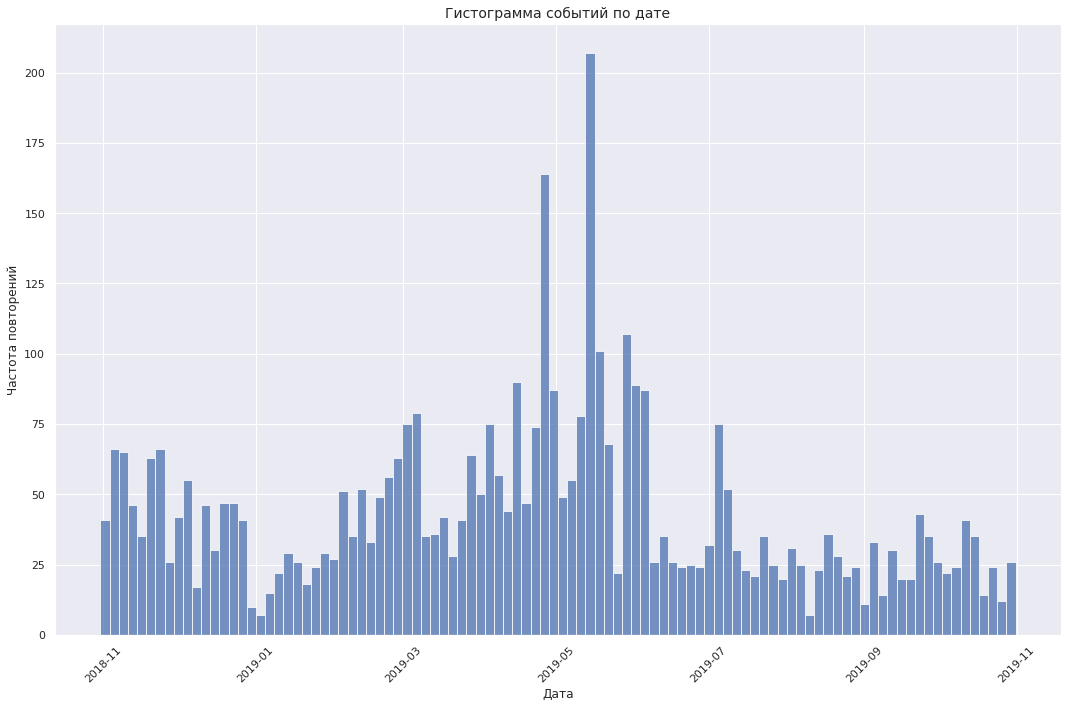

In [29]:
# Построение гистограммы количества событий в датасете по дате.
plt.figure(figsize=(15,10))
sns.histplot(df['date'], bins=100)
plt.title ('Гистограмма событий по дате', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Частота повторений')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Видим, что наибольшее число покупок товаров приходится на весенний период, что говорит о сезонности нашего интернет-магазина. Очевидно, что у нас в ассортименте имеется "сильная" сезонная категория - растения и рассада, которую покупатели покупают перед началом дачного сезона. Минимальное число покупок товаров приходится на осеннне-зимний период времени.

### Анализ покупателей магазина

In [30]:
# создадим сводную таблицу по клиентам нашего интернет-магазина
customer = df.pivot_table(
    index='customer_id', 
    values=['order_id', 'product', 'quantity', 'price','revenue'],
    aggfunc={'order_id':'nunique', 'product': 'nunique', 'quantity': 'sum', 'price':'mean', 'revenue': 'sum'}
).reset_index()

# расчитаем средний чек по каждому клиенту
customer ['avg_check'] = customer['revenue'] / customer['order_id']

customer.describe()

,order_id,price,product,quantity,revenue,avg_check
count,"2,220.00","2,220.00","2,220.00","2,220.00","2,220.00","2,220.00"
mean,1.13,711.02,1.90,3.73,"1,133.69","1,006.19"
std,2.25,947.51,3.95,7.89,"2,952.94","1,117.53"
min,1.00,14.00,1.00,1.00,14.00,14.00
25%,1.00,134.00,1.00,1.00,281.50,262.00
50%,1.00,329.00,1.00,1.00,659.50,630.50
75%,1.00,959.00,1.00,3.00,"1,417.25","1,230.25"
max,105.00,"6,134.00",110.00,203.00,"126,922.00","10,656.00"


Видим довольно низкое значение числа покупок на одного клиента - 1.13, что говорит о том, что абслотное большинство клиентов совершило только 1 покупку. Среднее число товаров в заказе клиентов-1.9. Среднее количество каждого товара в заказе - 3.81 шт.

При этом видим, что среди клиентов так же имеются "выбросы" - люди, совершившие 102 покупки, выбравшие 107 товаров в заказ, положившие 209 наименований одного товара в заказ. Подобные клиенты будут некорректно формировать наши кластеры клиентов, которые в будующем мы хотим получить. Уберем выбросы с помощью логической фильтрации.   

In [31]:
print('95 и 99 процентили для колонке количества заказов  = ', np.percentile(customer['order_id'], [95, 99]))
print('95 и 99 процентили для колонке product = ', np.percentile(customer['product'], [95, 99]))
print('95 и 99 процентили для колонке quantity = ', np.percentile(customer['quantity'], [95, 99]))

95 и 99 процентили для колонке количества заказов  =  [2. 3.]
95 и 99 процентили для колонке product =  [ 7. 18.]
95 и 99 процентили для колонке quantity =  [16. 30.]


In [32]:
ejection_customer = customer.query(('order_id > 3') or ('product > 18') or ('quantity > 30'))['customer_id']
display(ejection_customer)
customer = customer.query('customer_id not in @ejection_customer')
df = df.query('customer_id not in @ejection_customer')

15      0184f535-b60a-4914-a982-231e3f615206
991     73d1cd35-5e5f-4629-8cf2-3fda829d4e58
1580    b7b865ab-0735-407f-8d0c-31f74d2806cc
1646    bea7a833-2074-42db-bc49-4457abd3c930
1738    c971fb21-d54c-4134-938f-16b62ee86d3b
1945    e0535076-6270-4df2-8621-cb06264a94fa
Name: customer_id, dtype: object

Видим 6 клиентов. Данные по их заказам мы исключили из сводной таблице по клиентам и из основного датасета.

<div class="alert alert-warning">
    
  <b>Комментарий тимлида</b>
    
  ⚠️ Можно построить графики топ-5 или 10 самых продаваемых продуктов и т.д. Так сможем увидеть выбросы с ними.
    
</div>

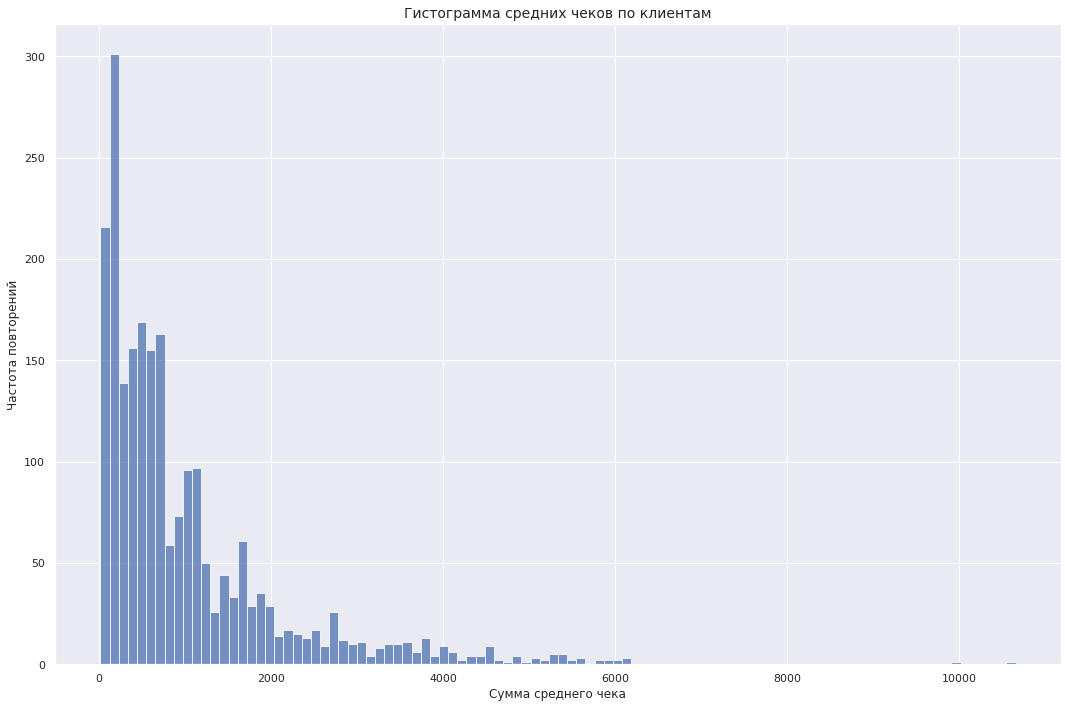

In [33]:
# гистограмма средних чеков по клиентам
plt.figure(figsize=(15,10))
sns.histplot(customer['avg_check'], bins=100)
plt.title ('Гистограмма средних чеков по клиентам', fontsize=14)
plt.xlabel('Сумма среднего чека')
plt.ylabel('Частота повторений')
plt.tight_layout()
plt.show()


Отметим, что наша гистограмма средних чеков  имеет общие черты нормального распределения значений, нам это потребуется для дальнейших исследований статистических гипотез. 

Однако у нашего распределения есть некоторые особенности. 

Имеется один ярко выраженный пик в районе минимального значения чека, очевидно, что  это покупки семян и прочих дешевых товаров в сезон. Далее имеются небольшие пики средних чеков в районе 500 рублей, 1000 рублей, 1500 рублей. Покупки со среднем чеком более 2000 рублей случаются редко, за рассматриваемый период таких случаев набралось менее 20 раз. С увеличением среднего чека снижается вероятность его получить, можно сказать что начиная с суммы в 4000 рублей покупки становятся крайне редки и носят единичный характер.

### Анализ категорий товаров

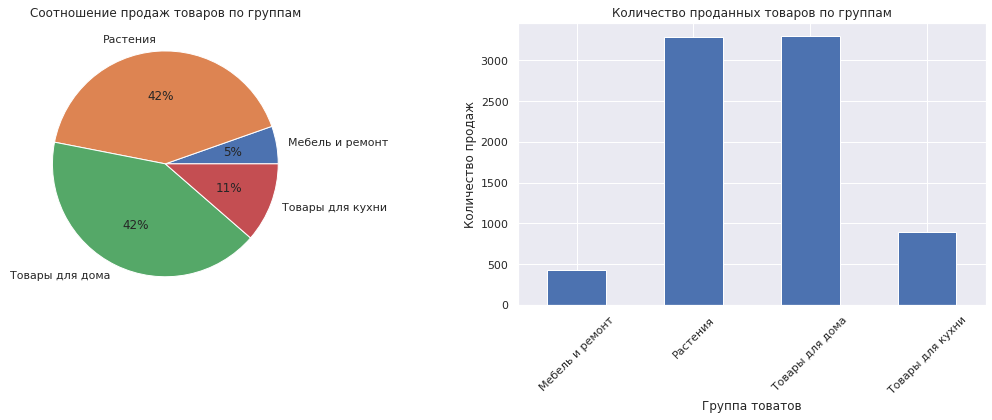

In [34]:
# построение гистограммы и круговой диаграммы по продажам товаров по группам клиентов
category_table = df.pivot_table(index = 'category', values='quantity', aggfunc='sum')

ax1 = plt.subplot(1, 2, 1)
category_table.plot(
    kind="pie",
    y = 'quantity',
    autopct='%.0f%%',
    title = 'Соотношение продаж товаров по группам',
    label =' ',
    legend =False, 
    ax = ax1)

ax2 = plt.subplot(1, 2, 2)
category_table.plot(
    kind="bar",
    title = 'Количество проданных товаров по группам',
    grid= True,
    ax = ax2,
    legend =False,
    figsize=(15, 6))
plt.xlabel('Группа товатов')
plt.ylabel('Количество продаж')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Видим, что абсолютные лидеры по количеству проданных товаров - категории "Растения" и "Товары для дома" - по 42% и 42% соотвественно, около 3200  раз попаданий в заказы клиентов. Товары для кухни занимают всего лишь  11% от проданных товаров, товары для ремонта и мебель - 5% или около 500 попаданий в заказы.

Рассмотрим категории товаров по их сезонности.

In [35]:
# создание сводной таблице сезонности товаров по категориям
season_category_table = df.pivot_table(
    index = 'category', 
    columns = 'season', 
    values=['quantity', 'revenue'], 
    aggfunc='sum'
).reset_index()

season_category_table

category quantity                    revenue             \
season                      Весна Зима Лето Осень      Весна       Зима   
0        Мебель и ремонт       97   90  106   133  98,706.00  95,909.00   
1               Растения     2023  363  589   308 246,351.00  63,395.00   
2        Товары для дома      942  840  669   844 291,801.00 358,408.00   
3       Товары для кухни      129  431   81   259  42,206.00 107,355.00   

                              
season       Лето      Осень  
0      110,620.00 102,382.00  
1       81,480.00  54,656.00  
2      255,466.00 352,130.00  
3       30,985.00  68,551.00

Можно отметить, что категории "Мебель и ремонт", "Товары для дома" лишены ярко выраженной сезонности продаж, имеются не критичные колебания в объемах выручки между временами года. 

В то же время у растений абсолютный пик по числу продаж товаров и выручки приходится на весну - 2022 раз оформлялись в заказ с выручкой в 241 тысячи рублей. 

Также видим сезонность в категории "товары для кухни", где в зимний период времен продается в 5 раз больше товаров по количеству и в 3 раза по выручке по сравнению с летом. 

Отметим значительный объем выручки и реализованных товаров в категории "товары для дома", данная категория стабильно приносит нам доход в течении всего года и ее можно назвать нашей основной категорией товаров.

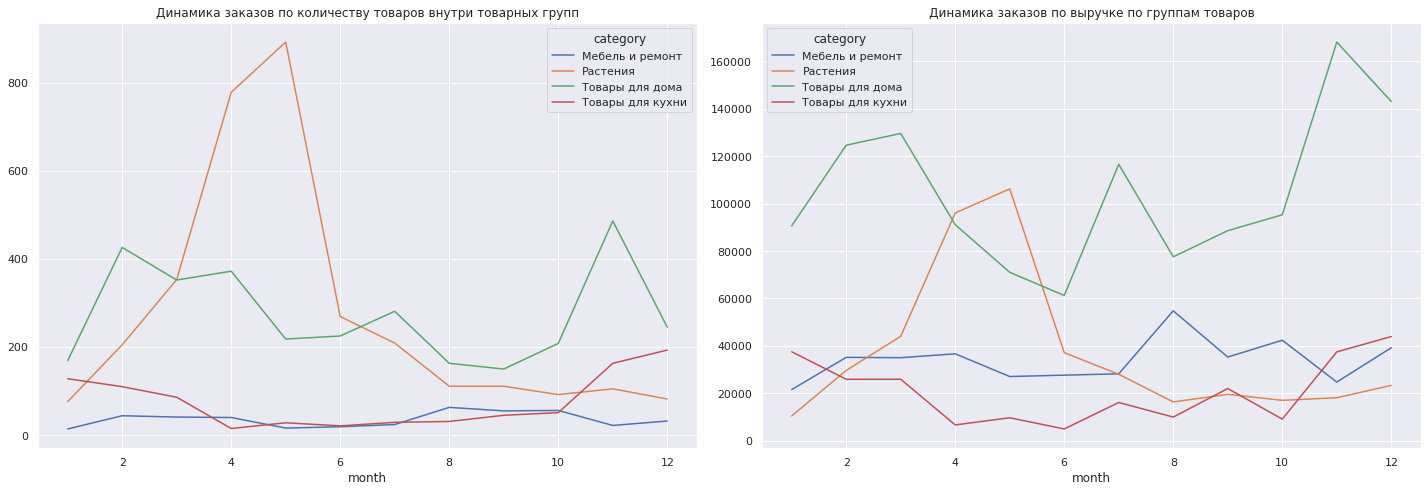

In [36]:
# построение графиков динамики выручки и количества проданных товаров по категориям
plt.figure(figsize=(20, 7))

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

df.pivot_table(
    index = 'month',
    columns = 'category',
    values='quantity',
    aggfunc='sum'
).plot(
    kind = 'line', 
    ax = ax1, 
    title = 'Динамика заказов по количеству товаров внутри товарных групп'
)


df.pivot_table(
    index = 'month',
    columns = 'category',
    values='revenue',
    aggfunc='sum'
).plot(
    kind = 'line',
    ax = ax2,
    title = 'Динамика заказов по выручке по группам товаров'
)

plt.tight_layout()
plt.show()

На графике хорошо видны пики количества проданных товаров в картегории "Растения".

In [37]:
#Для создания кумулятивной таблицы уберем значения часов из нашего датафрейма
df['date'] = df['date'].astype('datetime64[D]')

# создадим списко пар дат продаж и категорий товаров
dates_groups = df[['date', 'category']].drop_duplicates()

# Соберём агрегированные кумулятивные данные о заказах и покупателях по дням
order_agg = dates_groups.apply(lambda x: df[np.logical_and(df['date'] <= x['date'], df['category'] == x['category'])]
                                        .agg({'date': 'max', 'category': 'max', 'order_id': 'nunique',
                                              'customer_id': 'nunique', 'revenue': 'sum'}),
                                        axis=1).sort_values(by=['date', 'category'])

# Соберём агрегированные кумулятивные данные о товарах по дням
customers_agg = dates_groups.apply(lambda x: df[np.logical_and(df['date'] <= x['date'], df['category'] == x['category'])]
                                   .agg({'date': 'max', 'category': 'max', 'quantity': 'sum'}),
                                   axis=1).sort_values(by=['date', 'category'])

# Объединим кумулятивные данные в одной таблице и переименуем столбцы
cumulative_df = order_agg.merge(customers_agg, on=['date', 'category'])
cumulative_df.columns = ['date','category', 'orders', 'customers', 'revenue', 'quantity']
cumulative_df['avg_check'] = cumulative_df['revenue']/cumulative_df['orders']
cumulative_df.head(5)

,date,category,orders,customers,revenue,quantity,avg_check
0,2018-10-31,Мебель и ремонт,2,2,890.00,4,445.00
1,2018-10-31,Растения,1,1,101.00,1,101.00
2,2018-10-31,Товары для дома,3,3,"4,180.00",15,"1,393.33"
3,2018-10-31,Товары для кухни,1,1,149.00,1,149.00
4,2018-11-01,Мебель и ремонт,3,3,"1,632.00",5,544.00


In [38]:
# Функция построения сравнительного графика
def plot_group(df,  index):
    
    # где df - это датасет; index - фактор группировки

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # в таблице графиков — два столбца и одна строка, всего две ячейки
    # в первой строим кривые динамики кумулятивной выручки
    ax1 = plt.subplot(1, 2, 1)
    for idx in df[index].unique():
        func_df = df[df[index] == idx]
        plt.plot(func_df['date'], func_df['revenue'], label=idx)
    plt.xticks(rotation=45)  
    plt.legend()
    plt.xlabel('Дата')
    plt.ylabel('Выручка')
    plt.title('График куммулятивной выручки по '+index)
    
    # во второй ячейки графика строим кривую по среднему чеку клиента
    ax2 = plt.subplot(1, 2, 2)
    for idx in df[index].unique():
        func_df = df[df[index] == idx]
        plt.plot(func_df['date'], func_df['avg_check'], label=idx)
    plt.xticks(rotation=45)  
    plt.legend()
    plt.xlabel('Дата')
    plt.ylabel('Сумма среднего чека')
    plt.title('График среднего чека по '+index)
    
    
    plt.tight_layout()
    plt.show() 

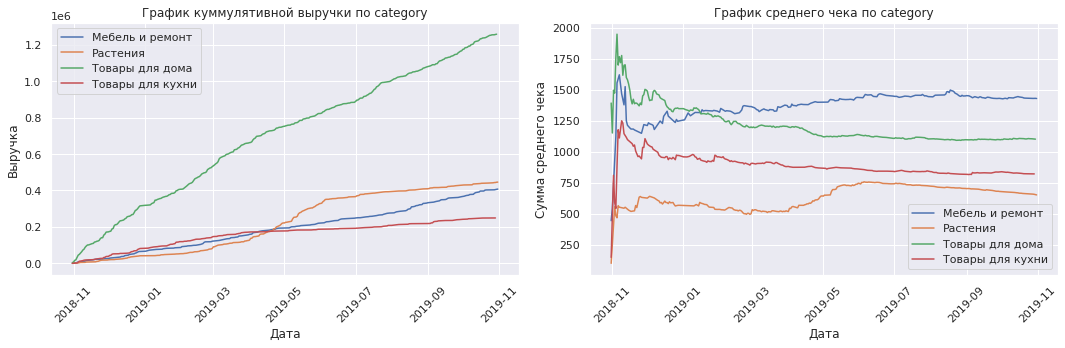

In [39]:
plot_group(cumulative_df, 'category')

Кумулятивная выручка от продажи товаров в категории "Товары для дома" в несколько раз (от 3 до 6 крат) превышает остальные категории. Отметим, что в течение года средний чек в категории "Товары для дома" снижался, и зафиксировался в районе 1000 рублей на 1 покупку. В то же время в январе 2019 года средний чек в категории "Мебель и ремонт" превысил средний чек в категории "Товары для дома" и зафиксировался в районе 1400 рублей. 
На графике среднего чека по категориям товаров хорошо видно сезонные колебания в категории "Товары для кухни" - рост в зимние месяца до 1200 рублей, далее к концу года плавное снижение до 800 рублей; в категории "Растения" - рост с 600 до 800 рублей в весенний период времени.

### Вывод

В ходе исследовательского анализа данных были убраны выбросы в исходном датасете  по столбцам  `quantity`, `price`, `revenue` по 99 перцентилю. 
На основе анализа сводной таблицы клиентов убраны выбросы с аномально большим числом заказов на 1 клиента, оформивших заказ с аномальным числом позиций товаров и положивших слишком много одноименных товаров в заказ.

Минимальная дата в первоначальных логах 2018-10-01.
Максимальная дата в первоначальных логах 2019-10-31.
Рассматриваемый период в выгрузке составляет 395 дней.
Для чистоты исследования оставим данные за 1 полный календарный год, убрав данные с "начала" датасета.

Наибольшее число покупок товаров приходится на весенний период, что говорит о сезонности нашего интернет-магазина. Очевидно, что у нас в ассортименте имеется "сильная" сезонная категория - растения и рассада, которую покупатели покупают перед началом дачного сезона. Минимальное число покупок товаров приходится на осеннне-зимний период времени.

На одного клиента приходится низкое значение числа заказов - всего 1.13, что указывает на то, что абслотное большинство клиентов совершило только 1 покупку. Среднее число товаров в заказе клиентов - 1.9. Среднее количество каждого наименования товара в заказе - 3.81 шт.

Абсолютные лидеры по количеству проданных товаров - категории "Растения" и "Товары для дома" - по 42% и 42% соотвественно, около 3200  раз попаданий в заказы клиентов. Товары для кухни занимают всего лишь  11% от проданных товаров, товары для ремонта и мебель - 5% или около 500 попаданий в заказы.

Можно отметить, что категории "Мебель и ремонт", "Товары для дома" лишены ярко выраженной сезонности продаж, имеются не критичные колебания в объемах выручки между временами года. 

В то же время у растений абсолютный пик по числу продаж товаров и выручки приходится на весну - 2022 раз оформлялись в заказ с выручкой в 241 тысячи рублей. 

Имеется сезонность в категории "Товары для кухни", где в зимний период времен продается в 5 раз больше товаров по количеству и в 3 раза по выручке по сравнению с летом. 

Категория "Товары для дома" имеет доминирующие положение по объему выручки и количеству реализованных товаров. Данная категория стабильно приносит нам доход в течении всего года и ее можно назвать нашей основной категорией товаров.

Кумулятивная выручка от продажи товаров в категории "Товары для дома" в несколько раз (от 3 до 6 крат) превышает остальные категории. В течение года средний чек в категории "Товары для дома" снижался, и зафиксировался в районе 1000 рублей на 1 покупку. В то же время в январе 2019 года средний чек в категории "Мебель и ремонт" превысил средний чек в категории "Товары для дома" и зафиксировался в районе 1400 рублей. На графике среднего чека по категориям товаров хорошо видно сезонные колебания в категории "Товары для кухни" - рост в зимние месяца до 1200 рублей, далее к концу года плавное снижение до 800 рублей; в категории "Растения" - рост с 600 до 800 рублей в весенний период времени.


## Сегментация покупателей на основе истории их покупок

### Создание сегментации на основании модели машинного обучения

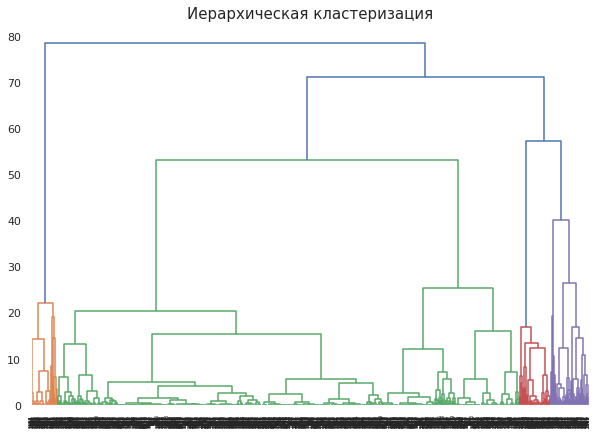

In [40]:
# по сводной таблице клиентов содадим набор данных для кластеризации
X = customer.drop(['customer_id'], axis = 1)

#обработаем данные и отрисуем дендрограмму кластериазции
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация', fontsize=15)
plt.show()

Согласно дендрограммы у нас имеется 4 кластера клиентов

In [41]:
# проведем кластеризацию и внесем в сводную таблицу клиентов номера кластеров
km = KMeans(n_clusters = 4, random_state = 0)
labels = km.fit_predict(X_st)
customer['cluster_km'] = labels

In [42]:
customer.head(5)

,customer_id,order_id,price,product,quantity,revenue,avg_check,cluster_km
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,138.75,4,4,555.00,555.00,0
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.00,1,1,442.00,442.00,0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,457.00,1,2,914.00,914.00,0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,"1,649.00",1,1,"1,649.00","1,649.00",0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,"1,162.00",1,2,"2,324.00","2,324.00",2


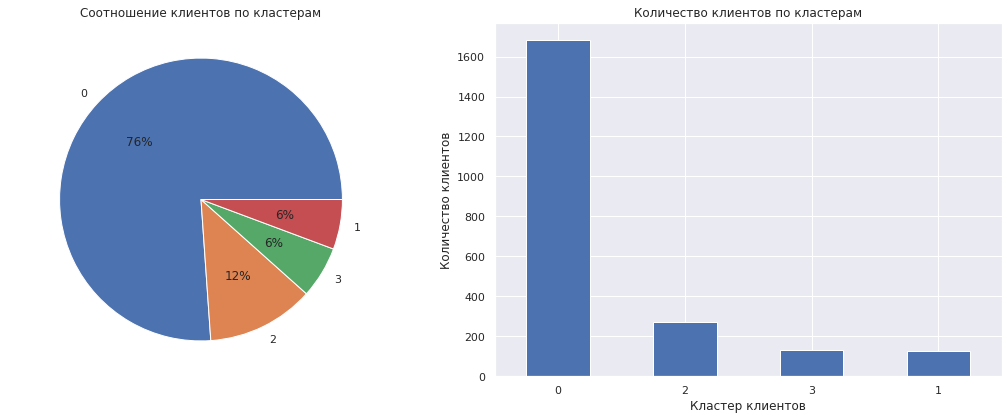

In [43]:
#отобразим распределение клиентов по полученым кластерам
cluster_table = customer['cluster_km'].value_counts()


ax1 = plt.subplot(1, 2, 1)
cluster_table.plot(
    kind="pie",
    y = 'quantity',
    autopct='%.0f%%',
    title = 'Соотношение клиентов по кластерам',
    label =' ',
    legend =False, 
    ax = ax1)

ax2 = plt.subplot(1, 2, 2)
cluster_table.plot(
    kind="bar",
    title = 'Количество клиентов по кластерам',
    grid= True,
    ax = ax2,
    legend =False,
    figsize=(15, 6))
plt.xlabel('Кластер клиентов')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Воспользовавшись алгоритмом кластеризации с помощью машинного обучения получили 4 кластера клиентов:

*Кластер 0:*
- 76% клиентов или 1685 человека


*Кластер 1:*
- 6% клиентов или 126 человек

*Кластер 2:*
- 12% клиентов или 272 человека

*Кластер 3:*
- 6% клиентов или 131 человек


In [44]:
customer.groupby('cluster_km').mean().T

cluster_km,0,1,2,3
order_id,1.00,2.13,1.03,1.06
price,461.38,414.84,"2,690.29",111.88
product,1.26,2.94,1.08,9.39
quantity,2.19,6.08,1.80,22.60
revenue,601.65,"1,244.59","3,335.29","2,157.24"
avg_check,601.65,584.01,"3,209.38","2,048.20"


*Кластер 0:*
- **оформляли только 1 заказ и больше не возвращались**
- в среднем 1,26 наименования товаров в количестве 2,19 шт.
- средний чек составил 601,65 рубль

*Кластер 1:*
- **2,13 заказов на клиента**
- в среднем 2,94 наименования в количестве 6,08 шт.
- выручка с одного клиента 1244 рубля
- средний чек 584,01 рубля

*Кластер 2:*
- оформляли 1,03 заказа
- в среднем закупали 1,08 наименования товаров в количестве 1,80 шт.
- **средняя цена товара - 3335,29 рублей, средний чек 3209,38 рублей**

*Кластер 3:*
- оформляли в среднем 1,06 заказов на клиента
- средняя цена товара в заказе составляет 111 рублей
- **в среднем 9,39 наименований в заказе в количестве 22,6 шт.**
- средний чек составил 2048,20 рублей


In [45]:
# присоединяем данные о кластерам клиентов в основной датасет
df_cluster = df.merge(customer[['customer_id','cluster_km']], on='customer_id', how='inner')

df_cluster.pivot_table(index = 'cluster_km', columns= 'category', values = ['quantity', 'revenue', 'order_id'], aggfunc = {'quantity':'sum', 'revenue':'sum', 'order_id': 'count'})

order_id                                            \
category   Мебель и ремонт Растения Товары для дома Товары для кухни   
cluster_km                                                             
0                      186      867             832              248   
1                       27      261             118               26   
2                       74       14             186               25   
3                        2     1099             115               48   

                  quantity                                            \
category   Мебель и ремонт Растения Товары для дома Товары для кухни   
cluster_km                                                             
0                      250     1173            1738              527   
1                       48      353             300               65   
2                       82       45             308               54   
3                       46     1712             949              254   

                   revenue                                              
category   Мебель и ремонт   Растения Товары для дома Товары для кухни  
cluster_km                                                              
0               165,158.00 192,094.00      508,002.00       148,530.00  
1                29,059.00  44,382.00       69,591.00        13,786.00  
2               211,760.00  31,303.00      602,152.00        61,985.00  
3                 1,640.00 178,103.00       78,060.00        24,796.00

*Кластер 0:*
- покупали в категории "товары для дома", "Растения". Хорошая выручка в категории "Мебель и ремонт", "Товары для кухни"


*Кластер 1:*
- отсутсвует ярко выражанные предпочтения по категориям товаров


*Кластер 2:*
- больше всего покупали в категории "Мебель и ремонт", "Товары для дома"

*Кластер 3:*
- закупка товаров в категории "Растения"

In [46]:
df_cluster.head(5)

,date,customer_id,order_id,product,quantity,price,revenue,weekday,month,category,season,cluster_km
0,2018-10-31,c5f7d5a6-c523-4e2c-bdf3-96a8dea6e00d,68807,Цветок искусственный Гвоздика пластиковая одиночная в ассортименте 50 см,10,21.00,210.00,2,10,Товары для дома,Осень,0
1,2018-10-31,3ee43256-af7d-4036-90d4-eeefa1afc767,14500,Рассада зелени для кухни Розмарина в горшке диам. 9 см,1,101.00,101.00,2,10,Растения,Осень,0
2,2018-10-31,65749106-bf0b-4cbf-90d4-797ed218473e,68809,"Корыто оцинкованное 45 л бесшовное, 1301031",4,749.00,"2,996.00",2,10,Товары для дома,Осень,2
3,2018-10-31,ad501a3a-19b7-4f38-8108-a6ee76b4bc7e,68810,Тележка багажная DELTA ТБР-20 черный с серым грузоподъемность 25 кг сумка 50 кг каркас РОССИЯ,1,742.00,742.00,2,10,Мебель и ремонт,Осень,0
4,2018-10-31,67cfb245-0080-46a1-a2e8-33a24a20103c,68811,"Штора для ванной комнаты 182х182 см ПВХ Meiwa, Krackle прозрачный 5911",1,974.00,974.00,2,10,Товары для дома,Осень,0


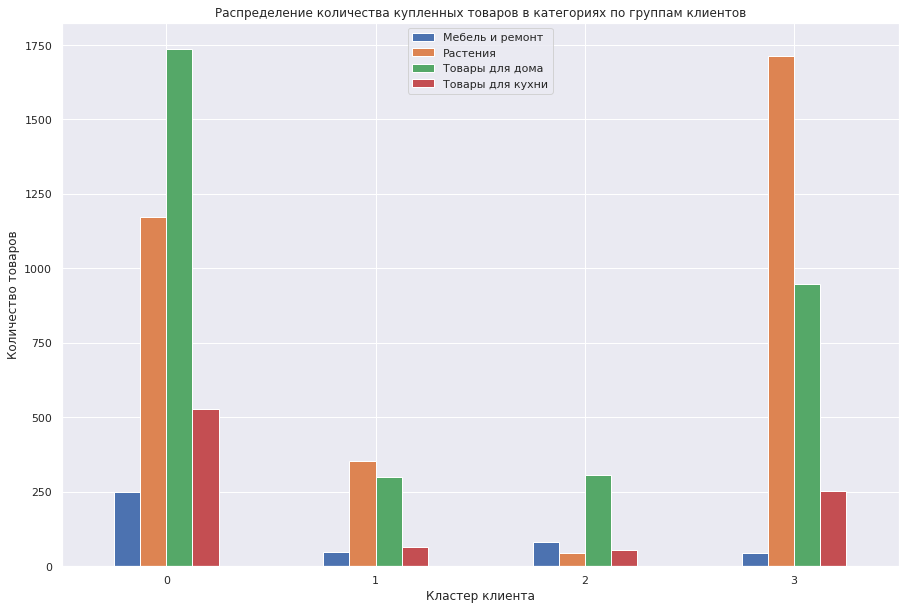

In [47]:
# Построение распределения количества купленных товаров в категориях по группам клиентов
df_cluster.pivot_table(
    index = 'cluster_km',
    columns = 'category',
    values = 'quantity',
    aggfunc = 'sum'
).plot(kind = 'bar', figsize=(15, 10))

plt.xlabel('Кластер клиента')
plt.ylabel('Количество товаров')
plt.title('Распределение количества купленных товаров в категориях по группам клиентов')
plt.xticks(rotation=0)
plt.legend() 
plt.show()

- в кластере 0 имеется доминирование категории "Товары для дома", "Растения" по количеству приобретенных товаров
- низкое количество проданных товаров в категории "Товары для дома", "Мебель и ремонт" в  кластерах 1 и 2
- в кластере 3 имеется доминирование категорий "Товары для дома", "Растения", а категория "Мебель и ремонт" представлена слабо

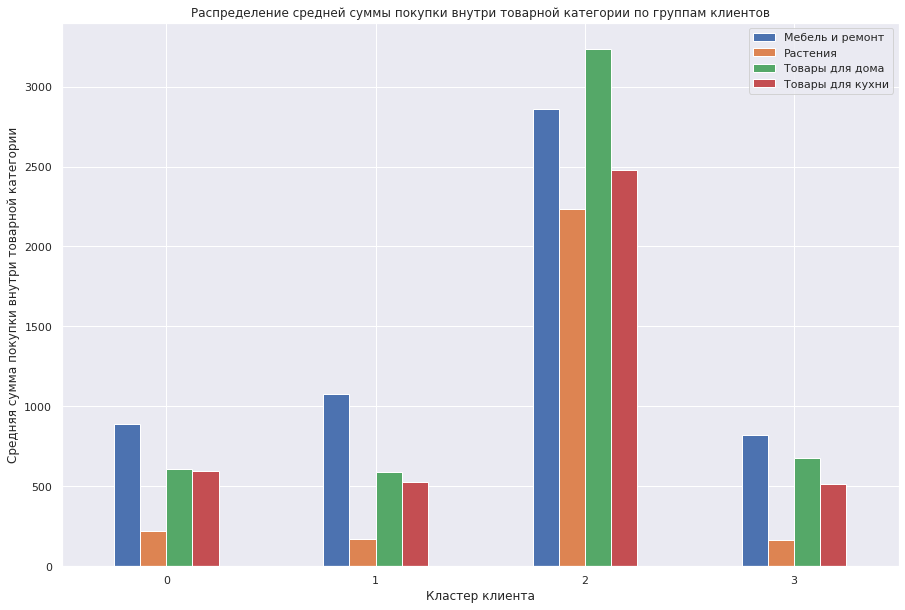

In [48]:
df_cluster.pivot_table(
    index = 'cluster_km',
    columns = 'category',
    values = 'revenue',
    aggfunc = 'mean'
).plot(kind = 'bar', figsize=(15, 10))

plt.xlabel('Кластер клиента')
plt.ylabel('Средняя сумма покупки внутри товарной категории')
plt.title('Распределение средней суммы покупки внутри товарной категории по группам клиентов')
plt.xticks(rotation=0)
plt.legend() 
plt.show()

По средней сумме покупок внутри товарных категорий по группам клиентов:
- существенные различия между кластерами 0, 1, 3 отсуствуют
- кластер 2 клиентов выделяется большими суммами покупок внутри каждой товарной группы 

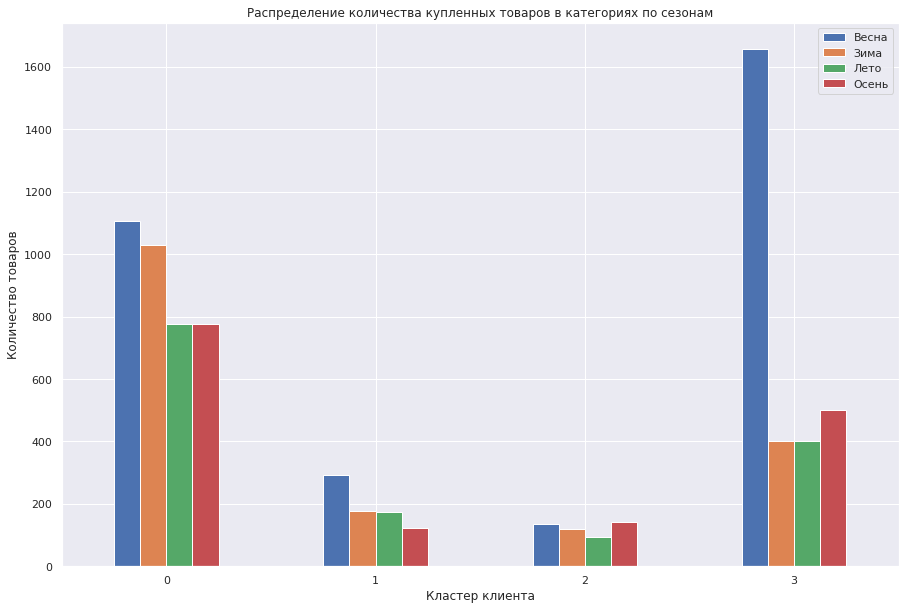

In [49]:
# График рспределения количества купленных товаров в категориях по сезонам
df_cluster.pivot_table(
    index = 'cluster_km', 
    columns = 'season', 
    values = 'quantity', 
    aggfunc = 'sum'
).plot(kind = 'bar', figsize=(15, 10))

plt.xlabel('Кластер клиента')
plt.ylabel('Количество товаров')
plt.title('Распределение количества купленных товаров в категориях по сезонам')
plt.xticks(rotation=0)
plt.legend() 
plt.show()

По количеству проданных товаров по сезонам внутри кластеров клиентов:
- в кластере 0  активнее покупатели весной и зимой, спрос в осень и лето одинаковый
- в кластере 1 активнее попатели весной, минимальная активность приходится на осень
- в кластере 2 сезонность практически не представлена
- в кластере 3 имеется сильный рост количества купленных товаров в весенний период, а так же небольшой рост активности осенью

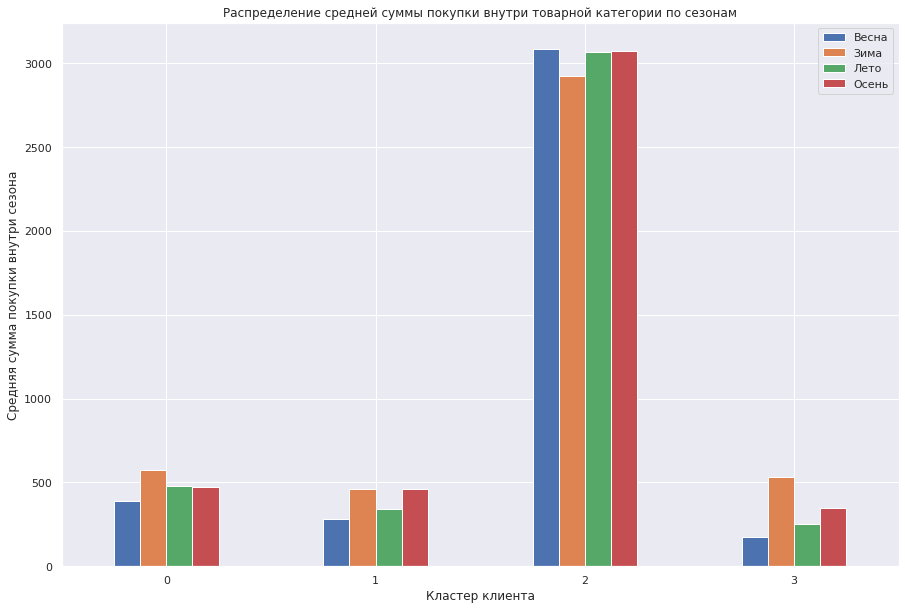

In [50]:
# Графки распределение средней суммы покупки внутри товарной категории по сезонам
df_cluster.pivot_table(
    index = 'cluster_km',
    columns = 'season',
    values = 'revenue',
    aggfunc = 'mean'
).plot(kind = 'bar', figsize=(15, 10))

plt.xlabel('Кластер клиента')
plt.ylabel('Средняя сумма покупки внутри сезона')
plt.title('Распределение средней суммы покупки внутри товарной категории по сезонам')
plt.xticks(rotation=0)
plt.legend() 
plt.show()

По средним суммам покупки внутри сезонов по кластерам клиентов сильно выделяется кластер 2, в то время как существенной разницы между кластерами 0, 1 , 3 нет

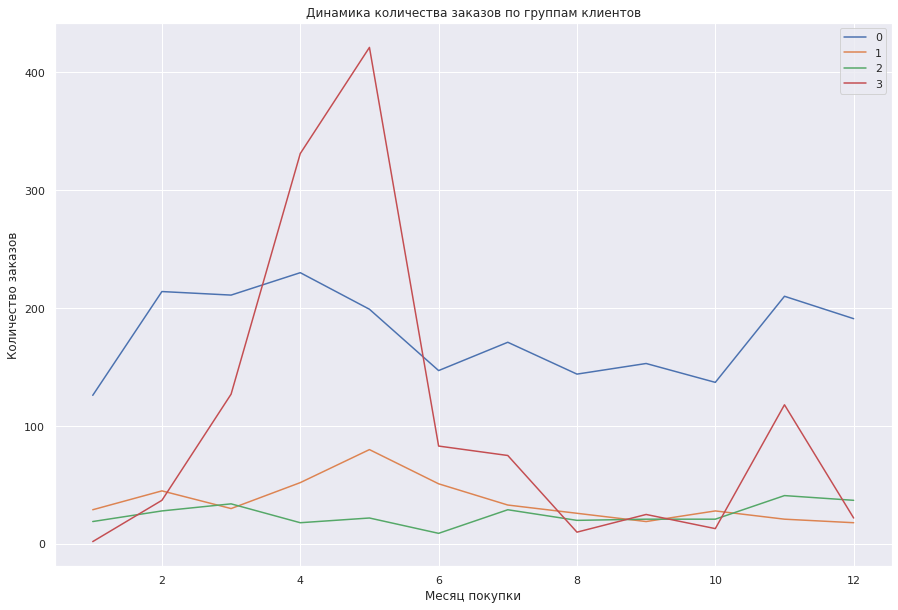

In [51]:
# постройка кривой динамики количества заказов по группам клиентов:
df_cluster.pivot_table(index = 'cluster_km', columns = 'month', values = 'order_id', aggfunc='count').T.plot(figsize=(15, 10))
plt.xlabel('Месяц покупки')
plt.ylabel('Количество заказов')
plt.title('Динамика количества заказов по группам клиентов')
plt.legend() 
plt.show()

*Кластер 0:*
- число заказов помесячно внутри кластера колеблется в интервале от 120 до 200 заказов ежемесячно
- небольшой рост активности в весенний период времени

*Кластер 1:*
- малое число заказов в течении года
- имеется небольшой подъем активности в весенний период времени

*Кластер 2:*
- ровная активность по количеству заказов в течении всего года

*Кластер 3:*
- имеется сезонность в весенний и зимний период времени

### Описание и общие выводы по кластерам клиентов

Воспользовавшись алгоритмом кластеризации с помощью машинного обучения получили 4 кластера клиентов:

*Кластер 0:*
- 76% клиентов или 1685 человека
- **оформляли только 1 заказ и больше не возвращались**
- в среднем 1,26 наименования товаров в количестве 2,19 шт.
- средний чек составил 601,65 рубль
- покупали в категории "товары для дома", "Растения". Хорошая выручка в категории "Мебель и ремонт", "Товары для кухни"
- число заказов помесячно внутри кластера колеблется в интервале от 120 до 200 заказов ежемесячно
- небольшой рост активности в весенний период времени

*Кластер 1:*
- 6% клиентов или 126 человек
- **2,13 заказов на клиента**
- в среднем 2,94 наименования в количестве 6,08 шт.
- выручка с одного клиента 1244 рубля
- средний чек 584,01 рубля
- отсутсвует ярко выражанные предпочтения по категориям товаров
- малое число заказов в течении года
- имеется небольшой подъем активности в весенний период времени

*Кластер 2:*
- 12% клиентов или 272 человека
- оформляли 1,03 заказа
- в среднем закупали 1,08 наименования товаров в количестве 1,80 шт.
- **средняя цена товара - 3335,29 рублей, средний чек 3209,38 рублей**
- больше всего покупали в категории "Мебель и ремонт", "Товары для дома"
- ровная активность по количеству заказов в течении всего года

*Кластер 3:*
- 6% клиентов или 131 человек
- оформляли в среднем 1,06 заказов на клиента
- средняя цена товара в заказе составляет 111 рублей
- **в среднем 9,39 наименований в заказе в количестве 22,6 шт.**
-  средний чек составил 2048,20 рублей
- закупка товаров в категории "Растения"
- имеется очень сильная сезонность в весенний период времени, меньше -  и зимний период 




## Проверка статистических гипотез

In [52]:
# зададим уровень значимости для иследований
alpha = 0.05

In [53]:
# функция для проведения статистических тестов

# где: df - обрабатываемый датасет, test_pair - тестируемая пара кластеров клиентов
# parameter - задаваемый тестовый параметр функции, по которому происходит сравнение
# time - сезон

def u_test(df, test_pair, parameter, time =  'вся выборка'):
    
    global all_test_resalt
    
    g1 = test_pair[0]
    g2 = test_pair[1]
    
    if time == 'вся выборка':
        p1 = df.query('cluster_km  == @test_pair[0]')[parameter]
        p2 = df.query('cluster_km  == @test_pair[1]')[parameter]
    else:
        p1 = df.query('cluster_km  == @test_pair[0]').query('season == @time')[parameter]
        p2 = df.query('cluster_km  == @test_pair[1]').query('season == @time')[parameter]
    
    results = st.mannwhitneyu(p1,p2)
    p_val = results.pvalue
    
    # вывод результатов функции на экран
    test = 'Проверка распределения средних значений {}   для групп  {} и {}, период: {} '.format(parameter, test_pair[0], test_pair[1], time)
    print(test)
    
    print('p-значение:', p_val)
    if p_val < alpha:
        message = "Отвергаем нулевую гипотезу: между распределением значений есть значимая разница"
        print(message)
    else:
        message = "Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными"
        print(message)
    print('*'*50)

    #запись результатов работы функции в таблицу данных
    u_test_resalt = {'u_test': test, 'p-value':p_val, 'resalt':message }
    u_test_resalt = pd.DataFrame (data = u_test_resalt, columns=['u_test','p-value','resalt'],index=[0])
    all_test_resalt = pd.concat([all_test_resalt, u_test_resalt], ignore_index=True)

In [54]:
# создадим таблицу для записи результатов тестов
all_test_resalt = pd.DataFrame(data=[], columns=['u_test','p-value','resalt'])

In [55]:
# создадим датасет для проведения статистических тестов
order = df_cluster.pivot_table(
    index = 'order_id', 
    values = ['season', 'cluster_km', 'revenue'],
    aggfunc = {'season':'first', 'cluster_km':'first', 'revenue':'sum'}
)


# зададим тестовые пары
pair = ([0, 1], [0, 2], [0,3], [1, 2], [1, 3], [2, 3])


### Проверка статистической гипотизы о равенстве средних чеков между группами покупателей

Сформируем гипотезы для проверки.

Нулевая гипотеза Н0: Распределение значений среднего чека внутри групп клиентов соответствует между собой. 

Альтернативная гипотеза Н1: Распределение значений среднего чека внутри групп клиентов (кластеров) не равно между собой.

Пороговое значение уровня значимости при проверки двух гипотез пример равной 5%.

In [56]:
# тест Шапиро-Уилк 
stat, p = st.shapiro(order['revenue']) 

print('Statistics=%.3f, p-value=%.3f'%(stat, p))

alpha = 0.05

if p > alpha:

    print('Принять гипотезу о нормальности')

else:

    print('Отклонить гипотезу о нормальности')

Statistics=0.751, p-value=0.000
Отклонить гипотезу о нормальности


<div class="alert alert-block alert-info">
  
  <b>Комментарий cтудента</b>
    
  Нормальность распределения отсутсвует, для тестирования необходимо применять критерий Манна-Уитни вместо t-test. Я перепишу функцию теста на новый метод тестирования. В разделах сформулированы новые нулевые и альтернативные гипотезы.
</div>

In [57]:
for i in range(len(pair)):
    u_test(df = order, test_pair = pair[i], parameter = 'revenue')

Проверка распределения средних значений revenue   для групп  0 и 1, период: вся выборка 
p-значение: 0.14883627435241323
Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными
**************************************************
Проверка распределения средних значений revenue   для групп  0 и 2, период: вся выборка 
p-значение: 6.536255193150064e-156
Отвергаем нулевую гипотезу: между распределением значений есть значимая разница
**************************************************
Проверка распределения средних значений revenue   для групп  0 и 3, период: вся выборка 
p-значение: 1.8694905484025935e-58
Отвергаем нулевую гипотезу: между распределением значений есть значимая разница
**************************************************
Проверка распределения средних значений revenue   для групп  1 и 2, период: вся выборка 
p-значение: 1.51149579714109e-88
Отвергаем нулевую гипотезу: между распределением значений есть значимая разница
********************

Между средними чеками кластеров 0 и 1 в периоде рассмотрения один год отсусвует статистическая значимость различий средних значений, принимаем нулевую гипотезу.

В остальных парах исследования средних чеков между кластерами нулевая гипотеза была отвегнута, в связи с чем делаем вывод о наличии статистической разницы между значениями средних чеков.

Рассмотрим, имеется ли статистическая разница между чеками кластеров в зависимости от сезона

### Проверка статистической гипотизы о равенстве средних чеков между группами покупателей внутри сезонов

Сформируем гипотезы для проверки.

Нулевая гипотеза Н0: Распределения значений средних чеков между группами покупателей (кластерами) внутри сезонов равно между собой. 

Альтернативная гипотеза Н1: Распределения значений средних чеков между группами покупателей (кластерами)  внутри сезонов не равно между собой.

Пороговое значение уровня значимости при проверки двух гипотез примем равной 5%.

In [58]:
season = ['Зима', 'Весна','Лето', 'Осень']

In [59]:
for i in range(len(pair)):
    for s in season:
        u_test(df = order, test_pair = pair[i], parameter = 'revenue', time = s)

Проверка распределения средних значений revenue   для групп  0 и 1, период: Зима 
p-значение: 0.1781338171389364
Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными
**************************************************
Проверка распределения средних значений revenue   для групп  0 и 1, период: Весна 
p-значение: 0.6087622312915763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными
**************************************************
Проверка распределения средних значений revenue   для групп  0 и 1, период: Лето 
p-значение: 0.9413353867875386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными
**************************************************
Проверка распределения средних значений revenue   для групп  0 и 1, период: Осень 
p-значение: 0.3784532110623534
Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными
*********

Проведенное тестирование показало, что между кластерами 0 и 1 внутри сезонов так же отсутсвует статистическая значимость разницы средних значений чеков, что говорит об однородности рассматриваемой выборки по данному параметру между кластерами. 


В остальные периоды значения средних чеков внутри кластеров имеют статистическую разницу между собой.

### Проверка уровня значимости при множественном тестировании


Т.к. мы проводили множественный тест, то  с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода.
Проведем поправку уровня значимости методом Бонферрони (поправка Бонферрони).

Уровни значимости в каждом из `m` сравнений в `m` раз меньше, чем уровень значимости, требуемый при единственном сравнении. Проще говоря, делим уровень значимости `alpha` на число проверенных гипотез.


In [60]:
bonferroni_alpha = alpha / all_test_resalt.shape[0]  # уровень критической значимости / количество сравнений
print('Уровень значимости согласно поправки Бонферрони составляет', bonferroni_alpha)

Уровень значимости согласно поправки Бонферрони составляет 0.0016666666666666668


Реализуем функцию сравнения имеющихся Р-результатов с уровнем критической значимости, принятым у четом поправики Бонферрони. Результаты запишем в нашу итоговую таблицу с тестами. 

In [61]:
def bonferroni(row, coef):
    pval = row['p-value']
    if (pval < coef):
        return("Отвергаем нулевую гипотезу: между распределением значений есть значимая разница")
    else:
        return("Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными")

In [62]:
all_test_resalt['bonferroni_alpha_checkup'] = all_test_resalt.apply(bonferroni, coef = bonferroni_alpha, axis = 1)

In [63]:
all_test_resalt

,u_test,p-value,resalt,bonferroni_alpha_checkup
0,"Проверка распределения средних значений revenue для групп 0 и 1, период: вся выборка",0.15,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными","Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными"
1,"Проверка распределения средних значений revenue для групп 0 и 2, период: вся выборка",0.00,Отвергаем нулевую гипотезу: между распределением значений есть значимая разница,Отвергаем нулевую гипотезу: между распределением значений есть значимая разница
2,"Проверка распределения средних значений revenue для групп 0 и 3, период: вся выборка",0.00,Отвергаем нулевую гипотезу: между распределением значений есть значимая разница,Отвергаем нулевую гипотезу: между распределением значений есть значимая разница
3,"Проверка распределения средних значений revenue для групп 1 и 2, период: вся выборка",0.00,Отвергаем нулевую гипотезу: между распределением значений есть значимая разница,Отвергаем нулевую гипотезу: между распределением значений есть значимая разница
4,"Проверка распределения средних значений revenue для групп 1 и 3, период: вся выборка",0.00,Отвергаем нулевую гипотезу: между распределением значений есть значимая разница,Отвергаем нулевую гипотезу: между распределением значений есть значимая разница
5,"Проверка распределения средних значений revenue для групп 2 и 3, период: вся выборка",0.00,Отвергаем нулевую гипотезу: между распределением значений есть значимая разница,Отвергаем нулевую гипотезу: между распределением значений есть значимая разница
6,"Проверка распределения средних значений revenue для групп 0 и 1, период: Зима",0.18,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными","Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными"
7,"Проверка распределения средних значений revenue для групп 0 и 1, период: Весна",0.61,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными","Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными"
8,"Проверка распределения средних значений revenue для групп 0 и 1, период: Лето",0.94,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными","Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными"
9,"Проверка распределения средних значений revenue для групп 0 и 1, период: Осень",0.38,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными","Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределения значений разными"


В ходе принятия уровня значимости с учетом поправки Бонферрони результаты тестов пересмотренны не были.

### Вывод

Всего было проведено 30 тестов, в ходе которых в 5 из них удалось зафиксировать подтверждение нулевой гипотезы об отстсвии статистической разницы средних чеков:
- между кластерами 0 и 1 на протяжении всего года
- между кластерами 0 и 1 на протяжении отдельных сезонов в течении всего года

Исходя из полученных результатов делаем вывод, что разница в значениях среднем чеки между группами 0 и 1 отсутствует, при сегментировании решющую роль сыграли прочие качественные характеристики клиентов.

Проверка результатов тестирования с учетом принятия уровня значимости с учетом поправки Бонферрони не дала пересмотра его результатов.

## Общие выводы и рекомендации

Первоначальная выгрузка данных содержала 6737 записей об операциях пользователей, сделанных 2451 пользователем. В магазине 2343 уникальных наименования продуктов, самый популярный - Рассада Кабачка сорт Зебра кассета 6 шт E6 - фигурировал в заказе 79 раз. Пользователь `1d6c8c1f-a799-4418-9af2-1ded47d7a85c` фигурировал в заказах 888 раз.

Описательная статистика первоночальной выгрузки показала, что в датасете имеются выбросы. Есть записи о покупке 1000 единиц товаров, при среднем значении количестве одного наименования в 2,5 единицы в рассматриваемом периоде. Даже если это оптовая покупка, то она является нетепичной для нашего магазина и как следствие будет считаться выбросом в данных. Так же отметим, что большинство товаров имеет не высокую стоимость. Медианная цена наших товаров составляет 135 рублей, 75% товаров умещаются по цене в 398 рублей. В тоже время значения средней цены товара в 462 рубля и большое значение (относительно наших средних) среднеквадратичного отклонения в 871.30 говорит, что в ассортименте так же предствалены довольно дорогостоящие (относительно доминирующих товаров с невысокой ценой) товары. 

При рассмотрении данных так же обнаружено, что при исключении из анализа столбца даты, в выгрузке имеются дубликаты данных.

Количество дубликатов после исключения столбца "дата" составило 1864 строк,  Количество строк в датафрейме после удаления дубликатов - 4873. ПРоизведено удаление 28% первоначальной выгрузки.

Обнаружена аномалия, при которой в один номер заказа объединялись покупки клиентов с разными id, исправлено путем их разделения в отдельные заказы с нумерацией, начинающейся на 90000.

В первоначальный датафрейм добавлены столбцы дня покупки, месяца, присвоен сезон совершения покупки, произведен расчет выручки от реализации отдельных позиций в заказе.

С помощью инструмента лемматизации сформировано и назначено 4 группы для наших товаров:
   - Растения
   - Товары для дома
   - Товары для кухни
   - Товары для ремонта и мебель

В ходе исследовательского анализа данных были убраны выбросы в исходном датасете  по столбцам  `quantity`, `revenue` по 99 перцентилю. 
На основе анализа сводной таблицы клиентов убраны выбросы с аномально большим числом заказов на 1 клиента, оформивших заказ с аномальным числом позиций товаров и положивших слишком много одноименных товаров в заказ.

Минимальная дата в первоначальных логах 2018-10-01.
Максимальная дата в первоначальных логах 2019-10-31.
Рассматриваемый период в выгрузке составляет 395 дней.
Для чистоты исследования оставим данные за 1 полный календарный год, убрав данные с "начала" датасета.

Наибольшее число покупок товаров приходится на весенний период, что говорит о сезонности нашего интернет-магазина. Очевидно, что у нас в ассортименте имеется "сильная" сезонная категория - растения и рассада, которую покупатели покупают перед началом дачного сезона. Минимальное число покупок товаров приходится на осеннне-зимний период времени.

На одного клиента приходится низкое значение числа заказов - всего 1.13, что указывает на то, что абслотное большинство клиентов совершило только 1 покупку. Среднее число товаров в заказе клиентов - 1.9. Среднее количество каждого наименования товара в заказе - 3.81 шт.

Абсолютные лидеры по количеству проданных товаров - категории "Растения" и "Товары для дома" - по 42% и 42% соотвественно, около 3200  раз попаданий в заказы клиентов. Товары для кухни занимают всего лишь  11% от проданных товаров, товары для ремонта и мебель - 5% или около 500 попаданий в заказы.

Можно отметить, что категории "Мебель и ремонт", "Товары для дома" лишены ярко выраженной сезонности продаж, имеются не критичные колебания в объемах выручки между временами года. 

В то же время у растений абсолютный пик по числу продаж товаров и выручки приходится на весну - 2022 раз оформлялись в заказ с выручкой в 241 тысячи рублей. 

Имеется сезонность в категории "Товары для кухни", где в зимний период времен продается в 5 раз больше товаров по количеству и в 3 раза по выручке по сравнению с летом. 

Категория "Товары для дома" имеет доминирующие положение по объему выручки и количеству реализованных товаров. Данная категория стабильно приносит нам доход в течении всего года и ее можно назвать нашей основной категорией товаров.

Кумулятивная выручка от продажи товаров в категории "Товары для дома" в несколько раз (от 3 до 6 крат) превышает остальные категории. В течение года средний чек в категории "Товары для дома" снижался, и зафиксировался в районе 1000 рублей на 1 покупку. В то же время в январе 2019 года средний чек в категории "Мебель и ремонт" превысил средний чек в категории "Товары для дома" и зафиксировался в районе 1400 рублей. На графике среднего чека по категориям товаров хорошо видно сезонные колебания в категории "Товары для кухни" - рост в зимние месяца до 1200 рублей, далее к концу года плавное снижение до 800 рублей; в категории "Растения" - рост с 600 до 800 рублей в весенний период времени.

Воспользовавшись алгоритмом кластеризации с помощью машинного обучения получили 4 кластера клиентов:


*Кластер 0:*
- 76% клиентов или 1685 человека
- **оформляли только 1 заказ и больше не возвращались**
- в среднем 1,26 наименования товаров в количестве 2,19 шт.
- средний чек составил 601,65 рубль
- покупали в категории "товары для дома", "Растения". Хорошая выручка в категории "Мебель и ремонт", "Товары для кухни"
- число заказов помесячно внутри кластера колеблется в интервале от 120 до 200 заказов ежемесячно
- небольшой рост активности в весенний период времени

*Кластер 1:*
- 6% клиентов или 126 человек
- **2,13 заказов на клиента**
- в среднем 2,94 наименования в количестве 6,08 шт.
- выручка с одного клиента 1244 рубля
- средний чек 584,01 рубля
- отсутсвует ярко выражанные предпочтения по категориям товаров
- малое число заказов в течении года
- имеется небольшой подъем активности в весенний период времени

*Кластер 2:*
- 12% клиентов или 272 человека
- оформляли 1,03 заказа
- в среднем закупали 1,08 наименования товаров в количестве 1,80 шт.
- **средняя цена товара - 3335,29 рублей, средний чек 3209,38 рублей**
- больше всего покупали в категории "Мебель и ремонт", "Товары для дома"
- ровная активность по количеству заказов в течении всего года

*Кластер 3:*
- 6% клиентов или 131 человек
- оформляли в среднем 1,06 заказов на клиента
- средняя цена товара в заказе составляет 111 рублей
- **в среднем 9,39 наименований в заказе в количестве 22,6 шт.**
-  средний чек составил 2048,20 рублей
- закупка товаров в категории "Растения"
- имеется очень сильная сезонность в весенний период времени, меньше -  и зимний период 


Всего было проведено 30 тестов, в ходе которых в 5 из них удалось зафиксировать подтверждение нулевой гипотезы об отстсвии статистической разницы средних чеков:
- между кластерами 0 и 1 на протяжении всего года
- между кластерами 0 и 1 на протяжении отдельных сезонов в течении всего года

Исходя из полученных результатов делаем вывод, что разница в значениях среднем чеки между группами 0 и 1 отсутствует, при сегментировании решющую роль сыграли прочие качественные характеристики клиентов.

Проверка результатов тестирования с учетом принятия уровня значимости с учетом поправки Бонферрони не дала пересмотра его результатов.


**РЕКОМЕНДАЦИИ**
- сфокусироваться на низкой доли повторных покупок внутри магазина, т.к. 76% клиентов сделали 1 заказ и не возращались к нам
- для Кластера 1 организовать переодические персональные предложения по всем категориям товаров с целью увеличения числа оформленных заказов, можно увеличить периодичность рассылки к весне с целью привлечения дополнитльных клиентов в категорию "Растения"
- для Кластера 0 предлагать сопуствующие товары из одноименных категорий для увеличения среднего чека
- для Кластера 2 реклама в категории "Мебель и ремонт", "Товары для дома" в течении всего года
- для Кластера 3 реклама в категории "Растения" в период весны и "Товары для кухни" зимой, а так же рассмотреть проведения маркенговых активностей для увеличения размера "пика" сезонности - акции "приведи друга" и т.д.
- рассмотреть вопрос о стимулириющих акциях направленных на возврат клиентов - бонусные программы, промоакции со скидками на следующие заказы
